In [1]:
# Import der benötigten Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline


In [2]:
# Funktion zur Kenngrößenbestimmung
# Input: Data Frame und Fläche in cm², Intensität in mW/cm²
a_anorg = 26
a_org = 0.064
def kenngroessen(df, area, intensity):
    df['j'] = df['current']/area
    plt.plot(df['voltage'], df['j'])
    u_0 = 0
    for i in range(len(df['voltage'])):
        if abs(df.at[i, 'voltage']) < abs(df.at[u_0, 'voltage']):
            u_0 = i
    i_0 = 0
    for i in range(len(df['j'])):
        if abs(df.at[i, 'j']) < abs(df.at[i_0, 'j']):
            i_0 = i
    mpp = 0
    I_largest = 0
    for I in list(df[(df['voltage']>0) & (df['voltage']<df.at[i_0, 'voltage'])].index):
        if abs(df.at[I, 'current']*df.at[I, 'voltage']) > mpp:
            mpp = abs(df.at[I, 'current']*df.at[I, 'voltage'])
            I_largest = I
    plt.scatter(df.at[i_0, 'voltage'], df.at[i_0, 'j'], marker='x')
    plt.scatter(df.at[u_0, 'voltage'], df.at[u_0, 'j'], marker='x')
    plt.scatter(df.at[I_largest, 'voltage'], df.at[I_largest, 'j'], marker='x')
    plt.xlabel('$V$  [V]')
    plt.ylabel('$j$  [A/cm²]')
    plt.tight_layout()
    ff = mpp / abs(df.at[i_0, 'voltage']*df.at[u_0, 'current'])
    eta = 100*mpp/(intensity*area/1000)
    j_sc = df.at[u_0, 'j']
    U_oc = df.at[i_0, 'voltage']
    return j_sc, U_oc, mpp, ff, eta


In [3]:


# A: Vergleich verschienener Solarzellen-Typen
A_anorg_hell = pd.read_csv('191121_FS_ST/anhell.dat', sep='\t')
A_anorg_dunkel = pd.read_csv('191121_FS_ST/anor.dat', sep='\t')

# Fit für Dunkelmessung Anorganische Zelle
A_anorg_dunkel_fit = A_anorg_dunkel[A_anorg_dunkel['current'] > 0.2]
A_anorg_dunkel_fit = A_anorg_dunkel_fit[A_anorg_dunkel_fit['current'] < 0.9]
def linear_fit(i, r, b):
    return  i * r + b
dunkel_fit, dunkel_var = curve_fit(linear_fit, A_anorg_dunkel_fit['current'], A_anorg_dunkel_fit['voltage'])


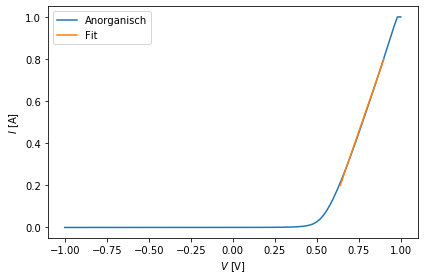

In [4]:
# Fit Dunkelkennlinie
plt.plot(A_anorg_dunkel['voltage'], A_anorg_dunkel['current'])
plt.plot([linear_fit(i, dunkel_fit[0], dunkel_fit[1]) for i in np.linspace(0.2, 0.8, 1000)], np.linspace(0.2, 0.8, 1000))
plt.legend(['Anorganisch', 'Fit'])
plt.xlabel('$V$ [V]')
plt.ylabel('$I$ [A]')
plt.tight_layout()
plt.savefig('images/fit.png', dpi=300)


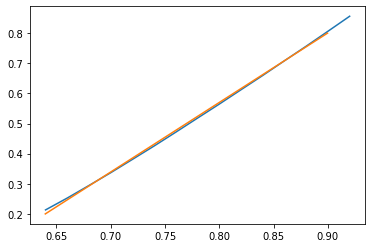

In [5]:
R_s = dunkel_fit[1]

plt.plot(A_anorg_dunkel_fit['voltage'], A_anorg_dunkel_fit['current'])
plt.plot([linear_fit(i, dunkel_fit[0], dunkel_fit[1]) for i in np.linspace(0.2, 0.8, 1000)], np.linspace(0.2, 0.8, 1000))

/home/felixsoest/Documents/studium/prak/prak/lib/python3.8/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


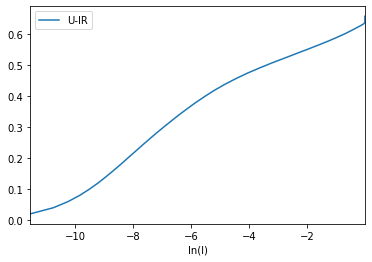

In [6]:
# Plot von U'
epsilon = 0.79
A_anorg_dunkel['U-IR'] = A_anorg_dunkel['voltage'] - (dunkel_fit[0]*epsilon) * A_anorg_dunkel['current']
A_anorg_dunkel['ln(I)'] = np.log(A_anorg_dunkel['current'])

A_anorg_dunkel.plot(4, 3)

In [7]:
# U' Fit
Data_for_fit = A_anorg_dunkel[A_anorg_dunkel['ln(I)']>-4]
log_fit, log_var = curve_fit(linear_fit, Data_for_fit['ln(I)'], Data_for_fit['U-IR'])
log_fit
k_b = 1.38e-23
e = 1.602e-19
T = 300
n = log_fit[0]*e/(k_b*T)
I_s = np.exp(-1*log_fit[1]/log_fit[0])
 

In [8]:
def exp_fit(I, a, i_s):
    return a * np.log((I + i_s)/i_s) + I * dunkel_fit[0]

fit, var = curve_fit(exp_fit, A_anorg_dunkel['current'], A_anorg_dunkel['voltage'])

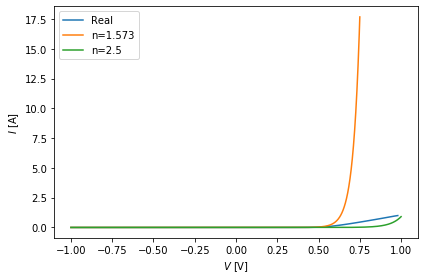

In [9]:
def schockley(U, n):
    return I_s * (np.exp(e*U/(n*k_b*T))-1)
plt.plot(A_anorg_dunkel['voltage'][A_anorg_dunkel['voltage']<1], A_anorg_dunkel['current'][A_anorg_dunkel['voltage']<1])
plt.plot(np.linspace(-1, .75, 1000), [ schockley(i, n) for i in np.linspace(-1,.75,1000)])
plt.plot(np.linspace(-1, 1, 1000), [ schockley(i, 2.5) for i in np.linspace(-1, 1, 1000)])
plt.legend(['Real', 'n=1.573', 'n=2.5'])
plt.xlabel('$V$ [V]')
plt.ylabel('$I$ [A]')
plt.tight_layout()
plt.savefig('images/realvsfit.png', dpi=300)

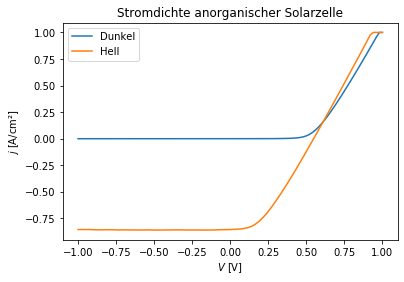

In [10]:
# Hell- und Dunkelkennlinie anorganische Zelle

# Berechnung j
A_anorg_dunkel['j'] = A_anorg_dunkel['current']/26
A_anorg_hell['j'] = A_anorg_hell['current']/26
plt.plot(A_anorg_dunkel['voltage'], A_anorg_dunkel['current'])
plt.plot(A_anorg_hell['voltage'], A_anorg_hell['current'])
plt.xlabel('$V$ [V]')
plt.ylabel('$j$ [A/cm²]')
plt.legend(['Dunkel', 'Hell'])
plt.title('Stromdichte anorganischer Solarzelle')
plt.savefig('images/a_hd_anorg.png', dpi=300)


<ipython-input-2-dea1c4d251b3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['j'] = df['current']/area


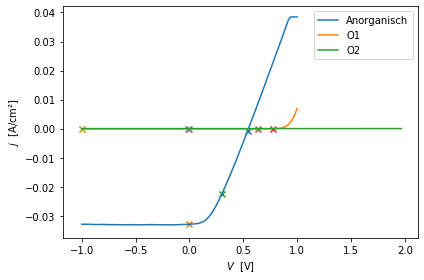

In [11]:
# Hellkennlinien
A_org_hell = pd.read_csv('191121_FS_ST/Bo1hell.dat', sep='\t')
A_org_hell_2 = pd.read_csv('191121_FS_ST/o2hell3.dat', sep='\t')
kenngroessen(A_anorg_hell, 26, 100)
kenngroessen(A_org_hell, 0.064, 100)
kenngroessen(A_org_hell_2[A_org_hell_2['voltage']<2], 25, 100)
plt.legend(['Anorganisch', 'O1', 'O2'])
plt.savefig('images/hell_all.png', dpi=300)


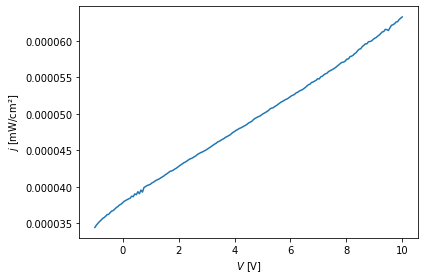

In [12]:
plt.plot(A_org_hell_2['voltage'], A_org_hell_2['current']/25)
plt.xlabel('$V$ [V]')
plt.ylabel('$j$ [mW/cm²]')
plt.tight_layout()
plt.savefig('images/o2.png')

Text(0, 0.5, '$j$ [A/cm²]')

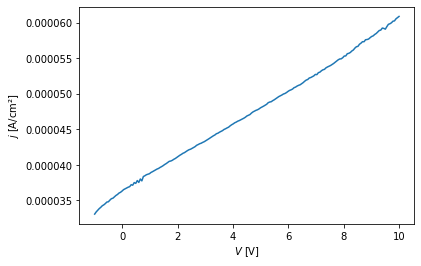

In [13]:
plt.plot(A_org_hell_2['voltage'], A_org_hell_2['current']/26)
plt.xlabel('$V$ [V]')
plt.ylabel('$j$ [A/cm²]')

In [14]:
# B: Der Einfluss der Beleuchtungsintensität
# Datenimport
B_an_2 = pd.read_csv('191121_FS_ST/B2anhe.dat', sep='\t')
B_an_4 = pd.read_csv('191121_FS_ST/B4anhe.dat', sep='\t')
B_an_8 = pd.read_csv('191121_FS_ST/B8anhe.dat', sep='\t')
B_an_16 = pd.read_csv('191121_FS_ST/B16anhe.dat', sep='\t')
B_org_2 = pd.read_csv('191121_FS_ST/B2o1he.dat', sep='\t')
B_org_4 = pd.read_csv('191121_FS_ST/B4o1he.dat', sep='\t')
B_org_8 = pd.read_csv('191121_FS_ST/B8o1he.dat', sep='\t')
B_org_16 = pd.read_csv('191121_FS_ST/B16ohe.dat', sep='\t')


<ipython-input-2-dea1c4d251b3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['j'] = df['current']/area


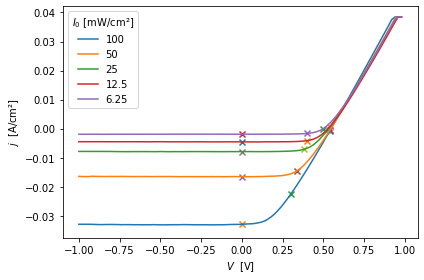

In [15]:
kenngroessen(A_anorg_hell[A_anorg_hell['voltage'] < 1], a_anorg, 100)
kenngroessen(B_an_2[B_an_2['voltage'] < 1], a_anorg, 50)
kenngroessen(B_an_4[B_an_4['voltage'] < 1], a_anorg, 25)
kenngroessen(B_an_8[B_an_8['voltage'] < 1], a_anorg, 12.5)
kenngroessen(B_an_16[B_an_16['voltage'] < 1], a_anorg, 6.25)
plt.legend(['100', '50', '25', '12.5', '6.25'], title='$I_0$ [mW/cm²]')
plt.savefig('images/B_anorganisch', dpi=300)


<ipython-input-2-dea1c4d251b3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['j'] = df['current']/area


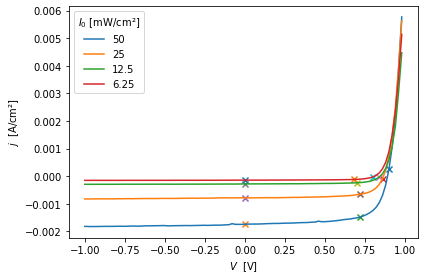

In [16]:
# kenngroessen(A_org_hell[A_org_hell['voltage']<1], a_org, 100)
kenngroessen(B_org_2[B_org_2['voltage'] < 1], a_org, 50)
kenngroessen(B_org_4[B_org_4['voltage'] < 1], a_org, 25)
kenngroessen(B_org_8[B_org_8['voltage'] < 1], a_org, 12.5)
kenngroessen(B_org_16[B_org_16['voltage'] < 1], a_org, 6.25)
plt.legend(['50', '25', '12.5', '6.25'], title='$I_0$ [mW/cm²]')
plt.savefig('images/B_organisch', dpi=300)


In [17]:
# Intensitäten und j_sc, U_OC
I_anorg = [100, 50, 25, 12.5, 6.25]
I_org = [50, 25, 12.5, 6.25]
j_sc_org = [-0.0017398078125, -0.0007834554687499999, -0.0002774175, -0.00014103653124999997]
U_OC_org = [0.9, 0.86, 0.84, 0.8]
j_sc_anorg = [-0.03289763846153847, -0.016498742307692306, -0.007866030769230769, -0.004531230769230768, -0.00189063]
U_OC_anorg = [0.54, 0.54, 0.54, 0.52, 0.5]


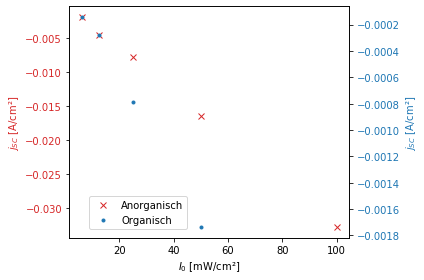

In [18]:
fig, ax1 = plt.subplots()

color = 'tab:red'
# ax1.set_xscale('log')
ax1.set_xlabel('$I_0$ [mW/cm²]')
ax1.set_ylabel('$j_{SC}$ [A/cm²]', color=color)
plt.errorbar(I_anorg, j_sc_anorg, fmt='x', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('$j_{SC}$ [A/cm²]', color=color)  # we already handled the x-label with ax1
plt.errorbar(I_org, j_sc_org, fmt='.', color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.legend(['Anorganisch', 'Organisch'], loc=(0.21, 0.18))
fig.tight_layout()
plt.savefig('images/b_j.png', dpi=300)


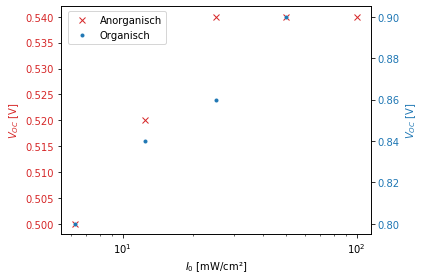

In [19]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xscale('log')
ax1.set_xlabel('$I_0$ [mW/cm²]')
ax1.set_ylabel('$V_{OC}$ [V]', color=color)
plt.errorbar(I_anorg, U_OC_anorg, fmt='x', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('$V_{OC}$ [V]', color=color)  # we already handled the x-label with ax1
plt.errorbar(I_org, U_OC_org, fmt='.', color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.legend(['Anorganisch', 'Organisch'], loc=(0.16, 0.84))
fig.tight_layout()
plt.savefig('images/b_V.png', dpi=300)

In [20]:

# C: Versuche an realistischen Verschaltungen
# Datenimport

C1 = pd.read_csv('191121_FS_ST/C1.dat', sep='\t')
CR1 = pd.read_csv('191121_FS_ST/CR1.dat', sep='\t')
CR2 = pd.read_csv('191121_FS_ST/CR2.dat', sep='\t')
CR3 = pd.read_csv('191121_FS_ST/CR3.dat', sep='\t')

CS1 = pd.read_csv('191121_FS_ST/CS1.dat', sep='\t')
CS2 = pd.read_csv('191121_FS_ST/CS2.dat', sep='\t')
CS3 = pd.read_csv('191121_FS_ST/CS3.dat', sep='\t')

CV1 = pd.read_csv('191121_FS_ST/CV1.dat', sep='\t')
CV2 = pd.read_csv('191121_FS_ST/CV2.dat', sep='\t')


<ipython-input-2-dea1c4d251b3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['j'] = df['current']/area


(-0.0008156198717948718,
 3.2,
 0.305749944,
 0.7509378779864614,
 5.879806615384616)

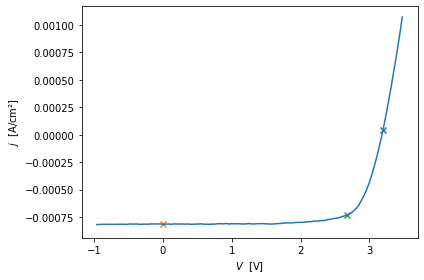

In [21]:
kenngroessen(C1[C1['voltage']<3.5], 6*a_anorg, 100/3)


<ipython-input-2-dea1c4d251b3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['j'] = df['current']/area


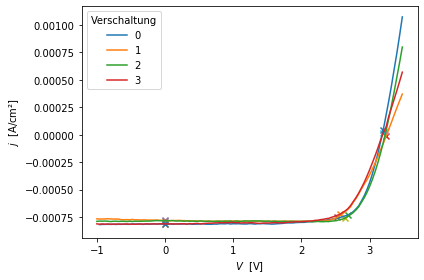

In [22]:

kenngroessen(C1[C1['voltage']<3.5], 6*a_anorg, 100/3)
kenngroessen(CR1[CR1['voltage']<3.5], 6*a_anorg, 100/3)
kenngroessen(CR2[CR2['voltage']<3.5], 6*a_anorg, 100/3)
kenngroessen(CR3[CR3['voltage']<3.5], 6*a_anorg, 100/3)
plt.legend([0,1,2,3], title='Verschaltung')
plt.savefig('images/schaltung.png', dpi=300)

<ipython-input-2-dea1c4d251b3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['j'] = df['current']/area


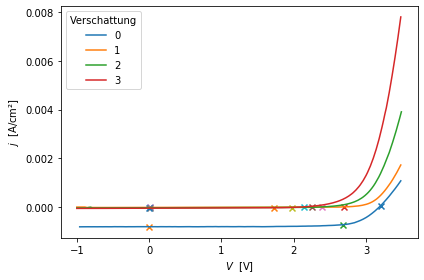

In [23]:
kenngroessen(C1[C1['voltage']<3.5], 6*a_anorg, 100/3)
kenngroessen(CS1[CS1['voltage']<3.5], 4*a_anorg, 100/3)
kenngroessen(CS2[CS2['voltage']<3.5], 2*a_anorg, 100/3)
kenngroessen(CS3[CS3['voltage']<3.5], a_anorg, 100/3)
plt.legend([0, 1, 2, 3], title='Verschattung')
plt.savefig('images/schatten.png', dpi=300)


<ipython-input-2-dea1c4d251b3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['j'] = df['current']/area


(-5.212161538461539e-05,
 1.98,
 0.001609104892,
 0.5996915781167406,
 0.18566594907692308)

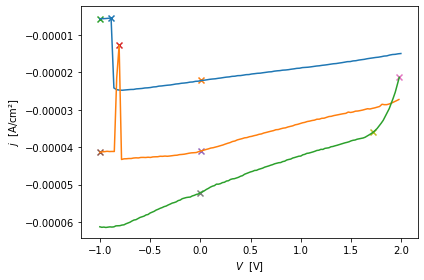

In [24]:
kenngroessen(CS1[CS1['voltage']<2], 4*a_anorg, 100/3)
kenngroessen(CS2[CS2['voltage']<2], 2*a_anorg, 100/3)
kenngroessen(CS3[CS3['voltage']<2], a_anorg, 100/3)



(-0.0004061128205128205,
 3.54,
 0.204978984,
 0.45698798329226886,
 1.9709517692307692)

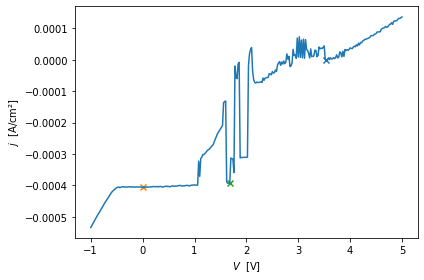

In [25]:
kenngroessen(CV1, 12*a_anorg, 100/3)

<ipython-input-2-dea1c4d251b3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['j'] = df['current']/area


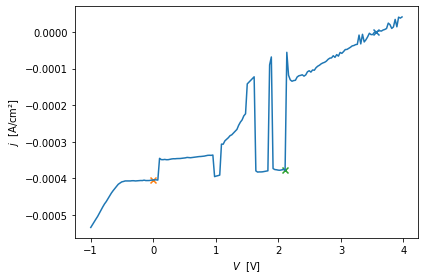

In [26]:
kenngroessen(CV2[CV2['voltage']<4], 12*a_anorg, 100/3)

plt.savefig('images/verbraucher.png', dpi=300)

In [27]:
# D: Der Einfluss der Temperatur
DT1 = pd.read_csv('191121_FS_ST/DT1.dat', sep='\t')
DT2 = pd.read_csv('191121_FS_ST/DT2.dat', sep='\t')

<ipython-input-2-dea1c4d251b3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['j'] = df['current']/area


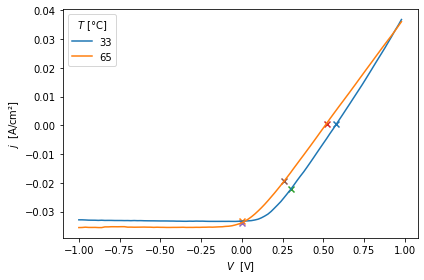

In [28]:
kenngroessen(DT1[DT1['voltage']<1], a_anorg, 100)
kenngroessen(DT2[DT2['voltage']<1], a_anorg, 100)
plt.legend([33, 65], title='$T$ [°C]')
plt.savefig('images/twotemps.png', dpi=300)

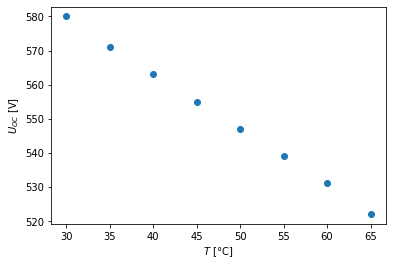

In [29]:
T = [30, 35, 40, 45, 50, 55, 60, 65]
V = [580, 571, 563, 555, 547, 539, 531, 522]
plt.scatter(T, V)
plt.xlabel('$T$ [°C]')
plt.ylabel('$U_{OC}$ [V]')
plt.savefig('images/alltemps.png', dpi=300)


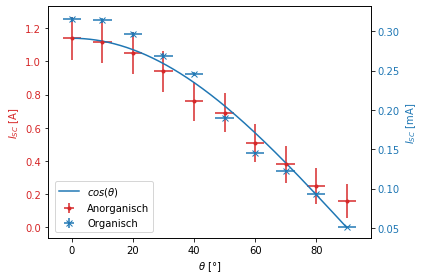

In [30]:
# E: Verhalten unter direkter/diffuser Bestrahlung
phi = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
I_an = [1.14, 1.12, 1.05, 0.94, .76, .69, .51, .38, .25, .16] #A
I_org = [0.315, 0.314, 0.296, .269, .246, .190, .145, .122, .093, .051] #mA

fig, ax1 = plt.subplots()
phi_plot = np.linspace(0, 90, 1000)
color = 'tab:red'
ax1.set_xlabel('$θ$ [°]')
ax1.set_ylabel('$I_{SC}$ [A]', color=color)
ax1.errorbar(phi, I_an, color=color, fmt='.', xerr=3, yerr=0.025*np.asarray(I_an)+.1)
ax1.plot(phi_plot, [np.cos(i*2*np.pi/360)*I_an[0] for i in phi_plot])
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('$I_{SC}$ [mA]', color=color)  # we already handled the x-label with ax1
ax2.errorbar(phi, I_org, color=color, fmt='x', xerr=3, yerr=0.01*np.asarray(I_org))
ax2.tick_params(axis='y', labelcolor=color)
fig.legend(['$cos(θ)$','Anorganisch', 'Organisch'], loc=(0.13, 0.17))
fig.tight_layout()
plt.savefig('images/e.png', dpi=300)